# **AG News Classification using Machine Learning**

#### Problem Statement:
Managing the ever-growing influx of news articles has become a complex task. Traditional methods of news classification struggle to keep up with the evolving language and diverse topics covered in articles.

#### Approach:
This project dives into the realm of news classification, aiming to compare the effectiveness of traditional Logistic Regression and Support Vector Classifier (SVC) with advanced transformer-based models like BERT and RoBERTa. The focus is on understanding the challenges, nuances in model training, and the ultimate goal of enhancing news categorization.

 This notebook contains intricacies of news classification, leveraging both conventional and cutting-edge machine learning techniques.


## **1. Notebook Setup**

#### Check if GPU is Available

In [ ]:
!nvidia-smi

Fri Dec 15 04:37:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |   9887MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Moudule Imports

In [ ]:
%pip install -q pyspark datasets transformers

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, load_dataset_builder

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel
from transformers import RobertaModel, RobertaTokenizer

import re
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from textblob import TextBlob

import logging
logging.basicConfig(level=logging.ERROR)

## **2. Data Loading and Preprocessing**

#### Initialize Spark Session

In [ ]:
# create a local spark session with name AG_News
spark = SparkSession.builder.master("local[*]").appName("AG_News").getOrCreate()

#### Load the AG News Dataset

In [ ]:
# load the AG News data and create a spark dataframe for preprocessing
data_builder = load_dataset_builder("ag_news")
class_names = data_builder.info.features['label'].names

print("Class Names:", class_names)

# load AG News dataset
data_train, data_test = load_dataset("ag_news", split=["train", "test"])

# create spark dataframe for preprocessing
df_train = spark.createDataFrame(pd.DataFrame(data_train))
df_test = spark.createDataFrame(pd.DataFrame(data_test))

print("\nSample Data:")
df_train.show(5)

Class Names: ['World', 'Sports', 'Business', 'Sci/Tech']

Sample Data:
+--------------------+-----+
|                text|label|
+--------------------+-----+
|Wall St. Bears Cl...|    2|
|Carlyle Looks Tow...|    2|
|Oil and Economy C...|    2|
|Iraq Halts Oil Ex...|    2|
|Oil prices soar t...|    2|
+--------------------+-----+
only showing top 5 rows



#### Process the Data for EDA and Training

In [ ]:
def sanitize(text):
    # Remove HTML, URLs, and special chars
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s.,\'"/\\-]', '', text)

    return text

# preprocess data for EDA and model training
sanitize_udf = udf(sanitize)

df_train = df_train.withColumn("text", sanitize_udf("text"))
df_test = df_test.withColumn("text", sanitize_udf("text"))

print("Processed Data:")
df_train.show(5)

Processed Data:
+--------------------+-----+
|                text|label|
+--------------------+-----+
|Wall St. Bears Cl...|    2|
|Carlyle Looks Tow...|    2|
|Oil and Economy C...|    2|
|Iraq Halts Oil Ex...|    2|
|Oil prices soar t...|    2|
+--------------------+-----+
only showing top 5 rows



## **3. Exploratory Data Analysis (EDA)**

In [ ]:
palette = "Set2"
fig_size = (8, 6)

# prepare data for visualization
def word_count(text):
    return len(text.split())

# count number of words
word_count_udf = udf(word_count, IntegerType())
df_train = df_train.withColumn("word_count",
                               word_count_udf("text"))

def sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# calculate sentiment polarity
sentiment_polarity_udf = udf(sentiment_polarity, FloatType())
df_train = df_train.withColumn("sentiment_polarity",
                               sentiment_polarity_udf("text"))

df_eda = df_train.toPandas()

#### Figure 1: Class Distribution

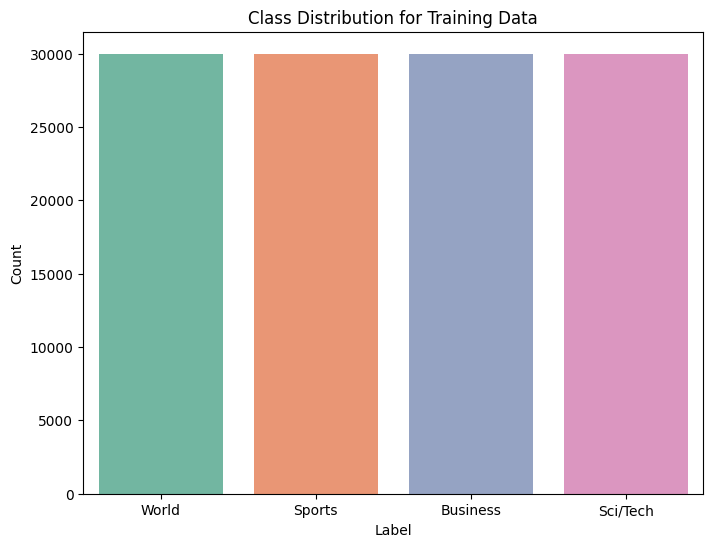

In [ ]:
# plot class distribution
plt.figure(figsize=fig_size)
sns.countplot(x="label",
              data=df_eda,
              palette=palette)
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.title("Class Distribution for Training Data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

#### Figure 2: Word Count by Class

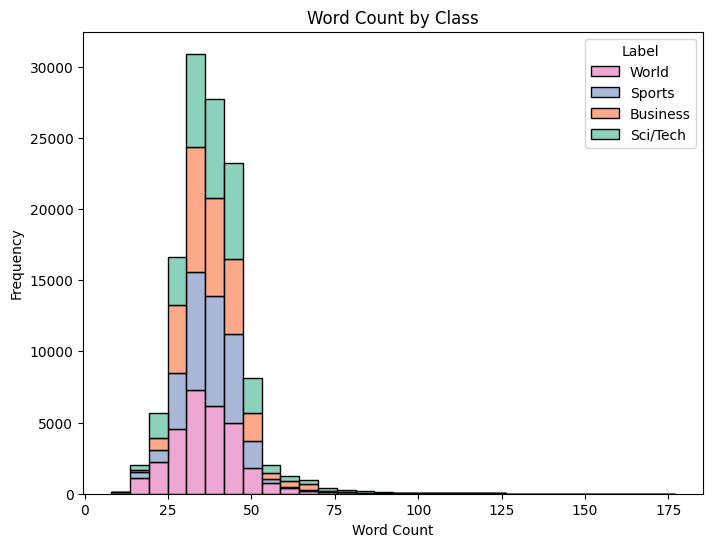

In [ ]:
# plot word count
plt.figure(figsize=fig_size)
sns.histplot(data=df_eda,
             x="word_count",
             bins=30,
             hue="label",
             multiple="stack",
             palette=palette)
plt.title("Word Count by Class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title="Label", labels=class_names)
plt.show()

#### Figure 3: Sentiment Polarity

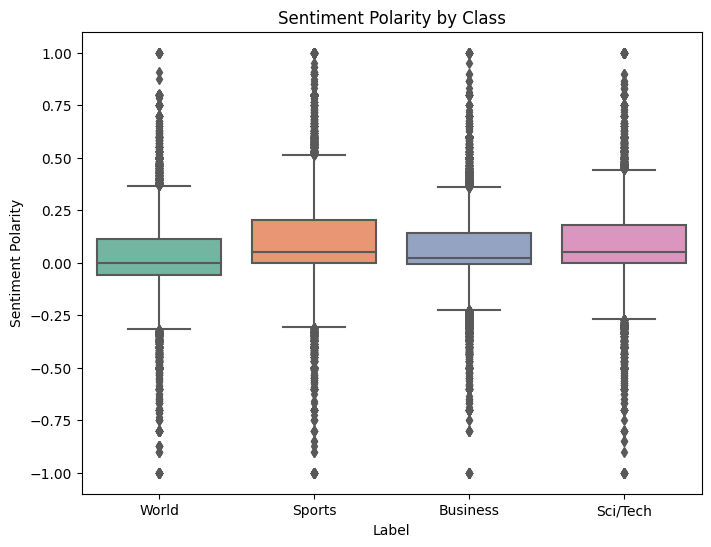

In [ ]:
# plot sentiment polarity by class
plt.figure(figsize=fig_size)
sns.boxplot(data=df_eda,
            x="label",
            y="sentiment_polarity",
            palette=palette)
plt.title("Sentiment Polarity by Class")
plt.xlabel("Label")
plt.ylabel("Sentiment Polarity")
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.show()

## **4. Logistic Regression and Support Vector Classifier (SVC)**

#### Utility Functions

In [ ]:
# utility function for displaying evaluation metrics
def print_metrics(y_true, y_pred, model):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    report = metrics.classification_report(y_true, y_pred)
    cf_matrix = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred),
                             index=[i for i in range(1,5)],
                             columns=[i for i in range(1,5)])

    print(f"Evaluation of {model}:")
    print(f"\nAccuracy: {round(accuracy*100,3)} %")
    print("\nClssification Report: \n", report)
    print("\nConfusion Matrix: ")

    plt.figure(figsize=(6,4));
    sns.heatmap(cf_matrix,
                linewidths=1,
                annot=True,
                square=True,
                fmt='d',
                cbar=False,
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues');
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

#### Prepare Data for Training

In [ ]:
# convert text data to numerical data using vectorizer
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data_train['text'])
y = data_train['label']

# divide data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train and Evaluate the Classifier

Evaluation of Logistic Regression:

Accuracy: 83.65 %

Clssification Report: 
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      5956
           1       0.89      0.94      0.91      6058
           2       0.83      0.75      0.79      5911
           3       0.79      0.80      0.79      6075

    accuracy                           0.84     24000
   macro avg       0.84      0.84      0.84     24000
weighted avg       0.84      0.84      0.84     24000


Confusion Matrix: 


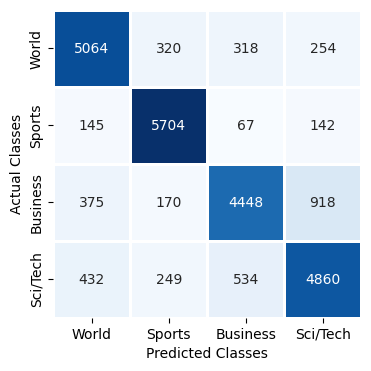

In [ ]:
# initialize and train the classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

# evaluate predictions
print_metrics(y_test, y_pred, "Logistic Regression")

Evaluation of Support Vector Classifier (SVC):

Accuracy: 86.387 %

Clssification Report: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      5956
           1       0.92      0.95      0.93      6058
           2       0.83      0.82      0.82      5911
           3       0.82      0.83      0.83      6075

    accuracy                           0.86     24000
   macro avg       0.86      0.86      0.86     24000
weighted avg       0.86      0.86      0.86     24000


Confusion Matrix: 


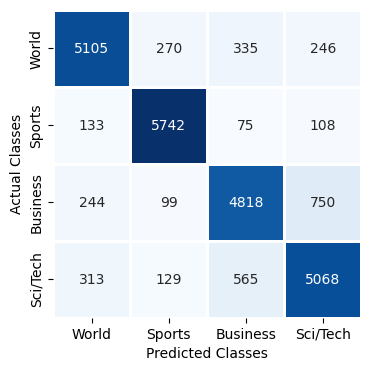

In [ ]:
# initialize and train the classifier
clf = SVC(kernel='linear')
clf.fit(X_train[:2400], y_train[:2400])

# make predictions
y_pred = clf.predict(X_test)

# evaluate predictions
print_metrics(y_test, y_pred, "Support Vector Classifier (SVC)")

## **5. Transformers: BERT and RoBERTa**

#### Utilize GPU if Available

In [ ]:
# use GPU if available
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


#### Prepare the Data

In [ ]:
# define global config variables
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
TRAIN_SIZE = 0.8

# define PyTorch dataset class
class NewsData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        # tokenize input
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
        )
        # return ids, mask, and token type for transformer
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# utility function to calculate accuracy
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

# utility function to visualize model training
def plot_train_val_metrics(res, model):
    # flatten dict array into single dict
    data_dict = {key: [item[key] for item in res] for key in res[0].keys()}

    plt.figure(figsize=(8, 8))

    plt.suptitle(f'{model} Performance Metrics')

    # plot train and val accuracy
    plt.subplot(2, 1, 1)
    sns.lineplot(data=data_dict['train_accu'], label='Train Accuracy')
    sns.lineplot(data=data_dict['val_accu'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot train and val loss
    plt.subplot(2, 1, 2)
    sns.lineplot(data=data_dict['train_loss'], label='Train Loss')
    sns.lineplot(data=data_dict['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# split the data into train, validation, and test splits
df = df_train.toPandas()
df_unseen = df_test.toPandas()
train_data = df.sample(frac=TRAIN_SIZE,random_state=42)
val_data = df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

#### BERT

In [ ]:
LEARNING_RATE = 1e-04

# inatialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# preparte PyTorch dataset
train_set = NewsData(train_data, tokenizer, MAX_LEN)
val_set = NewsData(val_data, tokenizer, MAX_LEN)
test_set = NewsData(df_unseen, tokenizer, MAX_LEN)

# create data loaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
    )

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0
    )

test_loader = DataLoader(
    test_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0
    )

# define BERT neural network
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(class_names))

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

# initialize network
model_bert = BertClass()
model_bert.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_bert.parameters(), lr=LEARNING_RATE)

# define training loop with validation
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model_bert.train()
    print("*"*20, "Epoch: ", epoch+1, "*"*20)
    for _,data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model_bert(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate train accuracy and loss
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Train Loss    : {epoch_loss}")
    print(f"Train Accuracy: {epoch_accu}")

    # validation
    model_bert.eval()
    val_loss = 0
    n_val_correct = 0
    nb_val_steps = 0
    nb_val_examples = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model_bert(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_val_correct += calcuate_accuracy(big_idx, targets)

            nb_val_steps += 1
            nb_val_examples += targets.size(0)

    # calculate validation accuracy and loss
    epoch_val_loss = val_loss / nb_val_steps
    epoch_val_accu = (n_val_correct*100) / nb_val_examples
    print(f"Validation Loss    : {epoch_val_loss}")
    print(f"Validation Accuracy: {epoch_val_accu}")

    return {
        'train_accu': epoch_accu,
        'val_accu': epoch_val_accu,
        'train_loss': epoch_loss,
        'val_loss': epoch_val_loss
    }

EPOCHS = 5
res_bert = []

# train the network
for epoch in range(EPOCHS):
    res_bert.append(train(epoch))

******************** Epoch:  1 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.39647495749096073
Train Accuracy: 87.1875


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.2617687929670016
Validation Accuracy: 91.20833333333333
******************** Epoch:  2 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.20034014711156486
Train Accuracy: 93.70833333333333


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.3651100535194079
Validation Accuracy: 89.70833333333333
******************** Epoch:  3 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.13973702859443923
Train Accuracy: 95.75


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.2510221476604541
Validation Accuracy: 92.54166666666667
******************** Epoch:  4 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.10900516329488406
Train Accuracy: 96.76041666666667


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.30776491122941174
Validation Accuracy: 91.54166666666667
******************** Epoch:  5 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.08821214449824766
Train Accuracy: 97.39583333333333


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.39950500167906283
Validation Accuracy: 91.125


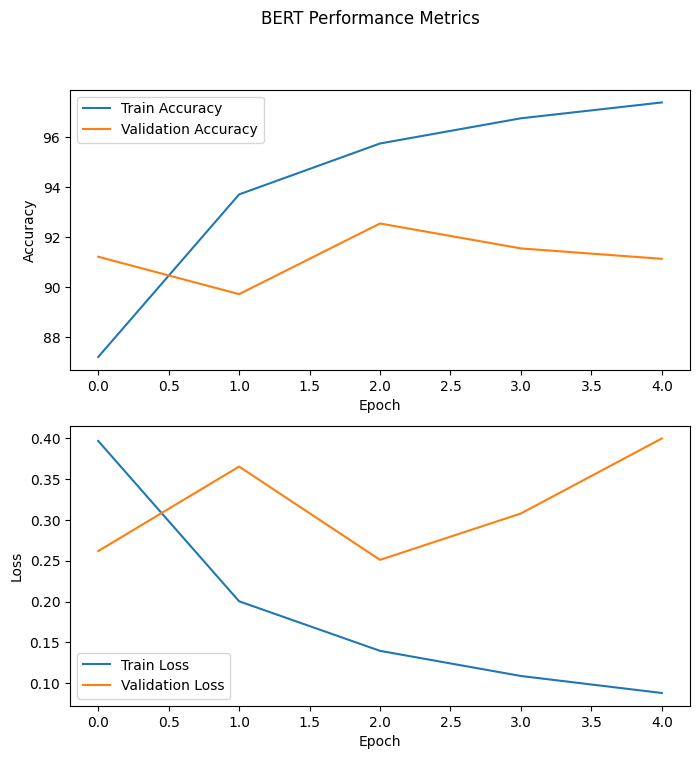

In [ ]:
plot_train_val_metrics(res_bert, "BERT")

  0%|          | 0/238 [00:00<?, ?it/s]

Evaluation of BERT:

Accuracy: 88.461 %

Clssification Report: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1900
           1       0.92      0.97      0.95      1900
           2       0.89      0.77      0.83      1900
           3       0.86      0.86      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Confusion Matrix: 


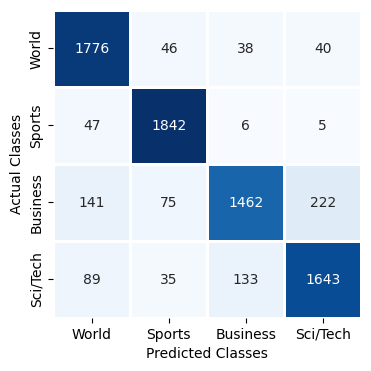

In [ ]:
y_true, y_pred = [], []

# evaluate on test dataset
def test(model, test_loader):
    model_bert.eval()
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            y_pred.extend(big_idx.tolist())
            y_true.extend(targets.tolist())

test(model_bert, test_loader)
print_metrics(y_true, y_pred, "BERT")

#### RoBERTa

In [ ]:
LEARNING_RATE = 1e-05

# inatialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# preparte PyTorch dataset
train_set = NewsData(train_data, tokenizer, MAX_LEN)
val_set = NewsData(val_data, tokenizer, MAX_LEN)
test_set = NewsData(df_unseen, tokenizer, MAX_LEN)

# create data loaders
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
    )

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0
    )

test_loader = DataLoader(
    test_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0
    )

# define RoBERTa neural network
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(class_names))

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

# initialize network
model_roberta = RobertaClass()
model_roberta.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_roberta.parameters(), lr=LEARNING_RATE)

prev_val_loss = np.inf

# define training loop with validation
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    global prev_val_loss
    model_roberta.train()
    print("*"*20, "Epoch: ", epoch+1, "*"*20)
    for _,data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model_roberta(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate train accuracy and loss
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Train Loss    : {epoch_loss}")
    print(f"Train Accuracy: {epoch_accu}")

    # validation
    model_roberta.eval()
    val_loss = 0
    n_val_correct = 0
    nb_val_steps = 0
    nb_val_examples = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model_roberta(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_val_correct += calcuate_accuracy(big_idx, targets)

            nb_val_steps += 1
            nb_val_examples += targets.size(0)

    # calculate validation accuracy and loss
    epoch_val_loss = val_loss / nb_val_steps
    epoch_val_accu = (n_val_correct*100) / nb_val_examples
    print(f"Validation Loss    : {epoch_val_loss}")
    print(f"Validation Accuracy: {epoch_val_accu}")

    if epoch_val_loss <= prev_val_loss:
        prev_val_loss = epoch_val_loss
        torch.save(model_roberta, "pytorch_roberta_ag_news.bin")
        tokenizer.save_vocabulary("./")
        print(f"MODEL SAVED: Validation Loss {prev_val_loss} -> {epoch_val_loss}")

    return {
        'train_accu': epoch_accu,
        'val_accu': epoch_val_accu,
        'train_loss': epoch_loss,
        'val_loss': epoch_val_loss
    }

EPOCHS = 5
res_roberta = []

# train the network
for epoch in range(EPOCHS):
    res_roberta.append(train(epoch))

******************** Epoch:  1 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.24318500755975644
Train Accuracy: 92.05208333333333


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.22822395925720532
Validation Accuracy: 92.75
MODEL SAVED: Validation Loss 0.22822395925720532 -> 0.22822395925720532
******************** Epoch:  2 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.16379402242600918
Train Accuracy: 94.83333333333333


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.19806785869101684
Validation Accuracy: 93.29166666666667
MODEL SAVED: Validation Loss 0.19806785869101684 -> 0.19806785869101684
******************** Epoch:  3 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.1265778168508162
Train Accuracy: 96.08333333333333


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.20394038468599318
Validation Accuracy: 93.95833333333333
******************** Epoch:  4 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.10102038882362346
Train Accuracy: 96.8125


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.2327285973293086
Validation Accuracy: 93.375
******************** Epoch:  5 ********************


  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss    : 0.0752246041301017
Train Accuracy: 97.79166666666667


  0%|          | 0/75 [00:00<?, ?it/s]

Validation Loss    : 0.23270976930856704
Validation Accuracy: 93.79166666666667


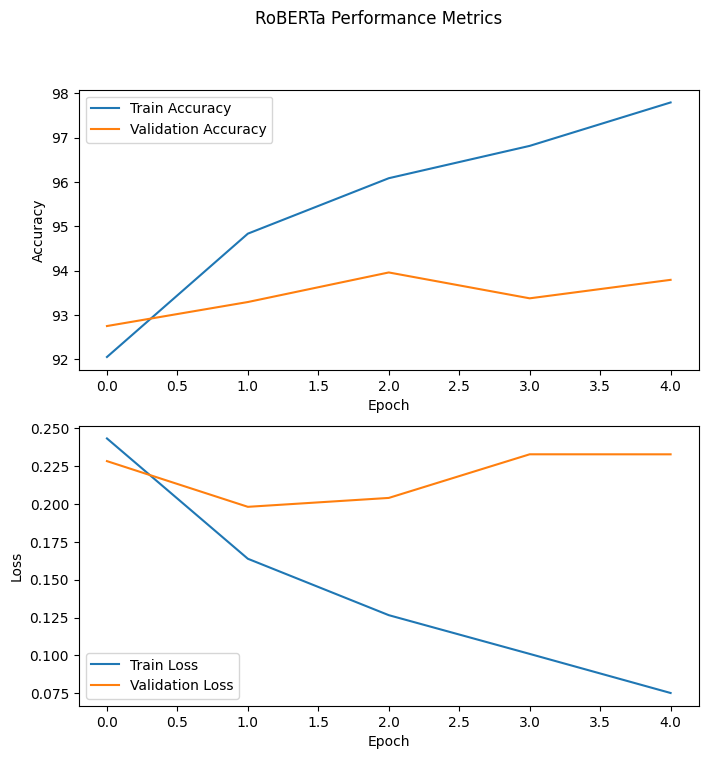

In [ ]:
plot_train_val_metrics(res_roberta, "RoBERTa")

  0%|          | 0/238 [00:00<?, ?it/s]

Evaluation of RoBERTa:

Accuracy: 91.895 %

Clssification Report: 
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      1900
           1       0.97      0.99      0.98      1900
           2       0.89      0.86      0.88      1900
           3       0.86      0.92      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600


Confusion Matrix: 


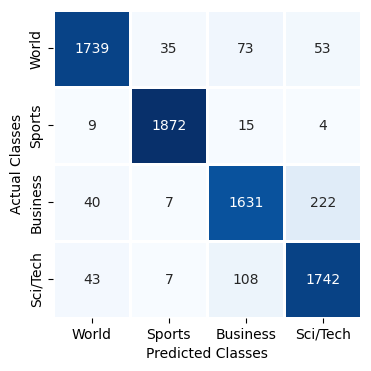

In [ ]:
y_true, y_pred = [], []

# evaluate on test dataset
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            y_pred.extend(big_idx.tolist())
            y_true.extend(targets.tolist())

model = torch.load("/content/pytorch_roberta_ag_news.bin")
test(model, test_loader)
print_metrics(y_true, y_pred, "RoBERTa")

## **6. Conclusion and Future Work**

#### Summary of Model Performances:

- Logistic Regression: Accuracy - 83.65%
- Support Vector Classifier (SVC): Accuracy - 86.39%
- BERT: Accuracy - 88.46%
- RoBERTa: Accuracy - 91.90%

#### Key Takeaways:

- RoBERTa outperformed other models, demonstrating the power of transformer-based architectures.
- Traditional models like Logistic Regression and SVC also showcased competitive accuracy.
- The choice of model significantly impacts the performance of news classification.

#### Conclusion:

This project delved into the world of news classification, evaluating the efficacy of traditional and deep learning models. RoBERTa emerged as the top performer, emphasizing the importance of leveraging state-of-the-art architectures for complex tasks like news categorization.

#### Future Work:

- Fine-tune models: Explore hyperparameter tuning for further optimization.
- Ensemble models: Investigate combining predictions from multiple models for enhanced robustness.
- Bias analysis: Assess and mitigate any inherent biases in the models.
- Continuous monitoring: Implement strategies for ongoing model evaluation and updates.

#### Wrapping Up

This project has been a thrilling experience, allowing me to dive deep into the realm of news classification using various models. Along the way, I've gained valuable insights into the intricacies of transformer-based models, traditional machine learning, and the challenges posed by real-world datasets.

Working on this project has not only enhanced my technical skills but also provided a profound understanding of the importance of effective communication through data. The journey has been both educational and enjoyable.

I've learned many things about the nuances of natural language processing, the significance of balanced datasets, and the delicate dance between model complexity and computational resources.

Happy coding and exploring!
